abortion access dataset analysis

In [1]:
import pandas as pd
import geopandas as gpd
import folium 
import matplotlib.pyplot as plt
import mapclassify
%config InlineBackend.figure_format ='retina'

In [13]:
abortionaccessfull = pd.read_csv('../data/2024.05.01_abortionaccess_countyxmonth.csv')

In [4]:
## CLEANING

# eliminating all monthly observations to just January of each year
abortionaccess = abortionaccessfull[abortionaccessfull['month'] == 1]
abortionaccess['origin_fips_code'] = abortionaccess['origin_fips_code'].astype(int)

/tmp/ipykernel_4055993/137635014.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abortionaccess['origin_fips_code'] = abortionaccess['origin_fips_code'].astype(int)


In [5]:
gdf = gpd.read_file('../data/tl_2023_us_county.zip')
gdf['GEOID'] = gdf['GEOID'].astype(int)

In [6]:
# ANALYSIS

# mapping a certain year and all the distances to abortion clinics by county

#AK and HI eliminated for readability of map

abortionMAP = abortionaccess.merge(gdf, left_on='origin_fips_code', right_on='GEOID', how='inner').drop(columns = ['GEOID', 'MTFCC', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOIDFQ',	'NAME',	'NAMELSAD',	'LSAD',	'CLASSFP', 'CSAFP'])
abortionMAP = gpd.GeoDataFrame(abortionMAP)

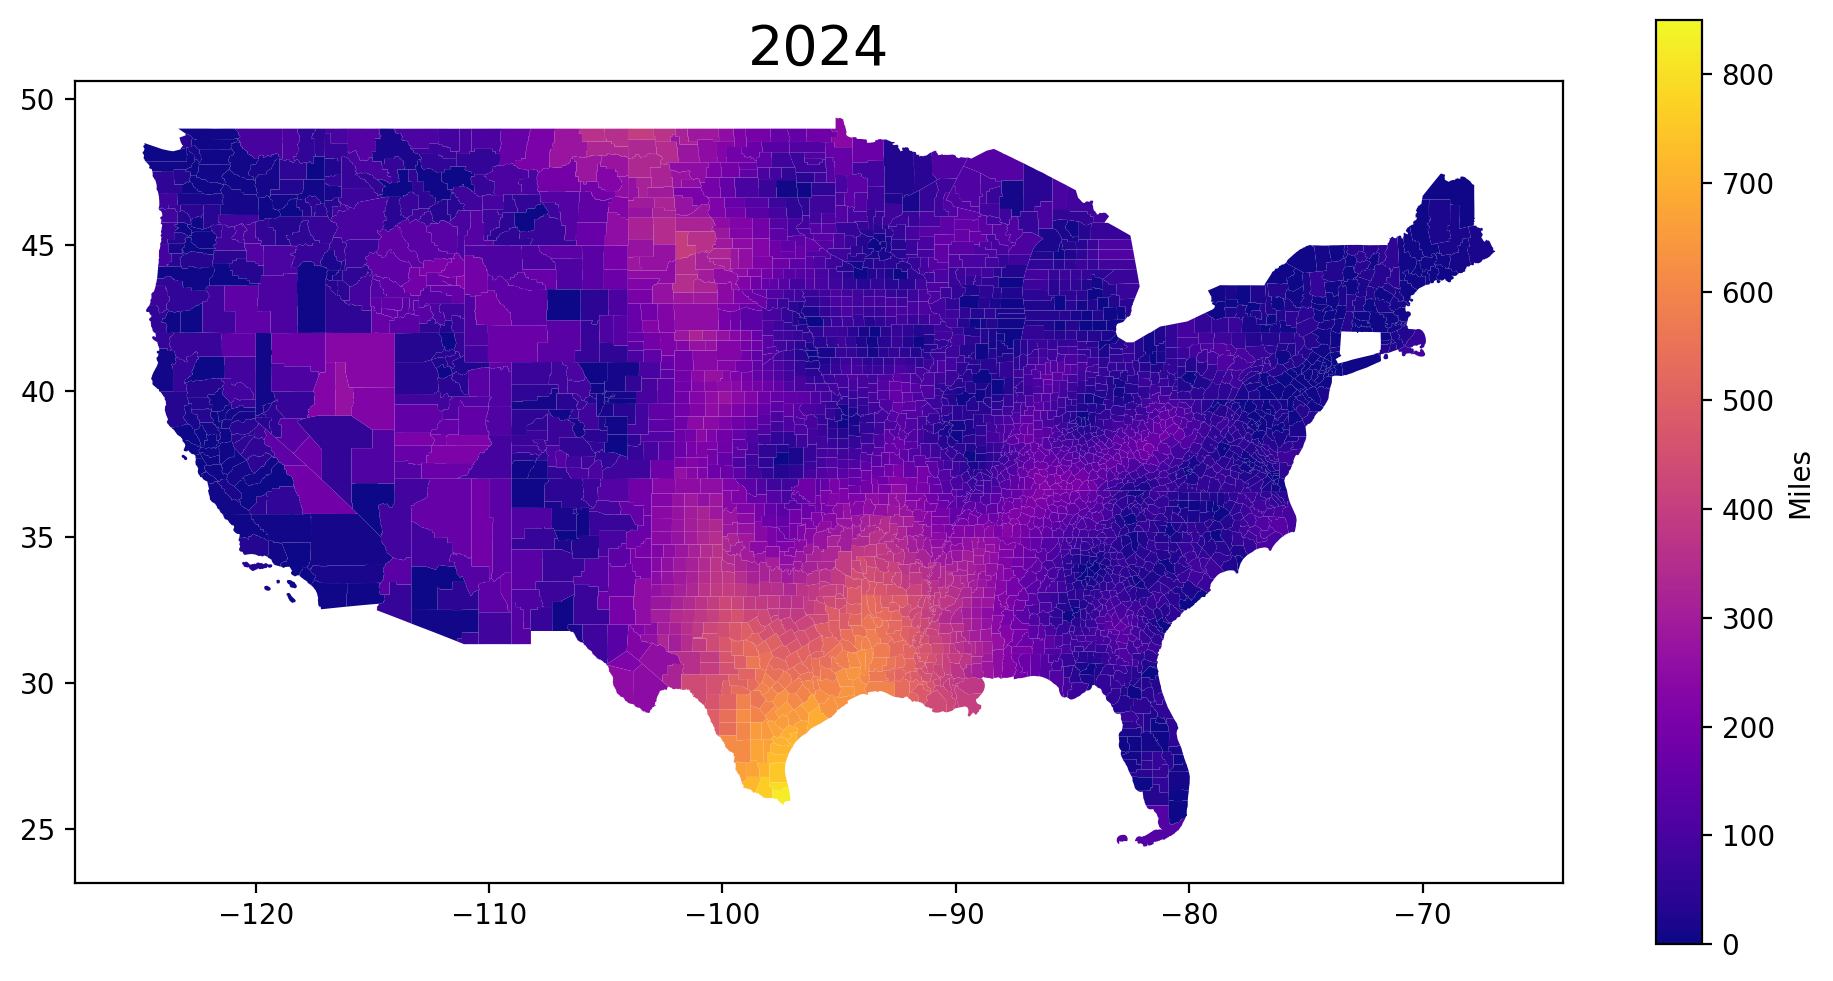

In [22]:
abortionMAP09 = abortionMAP[(abortionMAP['year'] == 2024) & (abortionMAP['origin_state'] != 'HI') & (abortionMAP['origin_state'] != 'AK')]
yearplot = abortionMAP09.plot('distance_origintodest', 
                   figsize=(12,6),
                   cmap = 'plasma',
                   legend = True, vmin = 0, vmax = 850,
                    legend_kwds={'label': "Miles",
                         'orientation': "vertical"});
yearplot.set_title('2024', fontsize = 20);

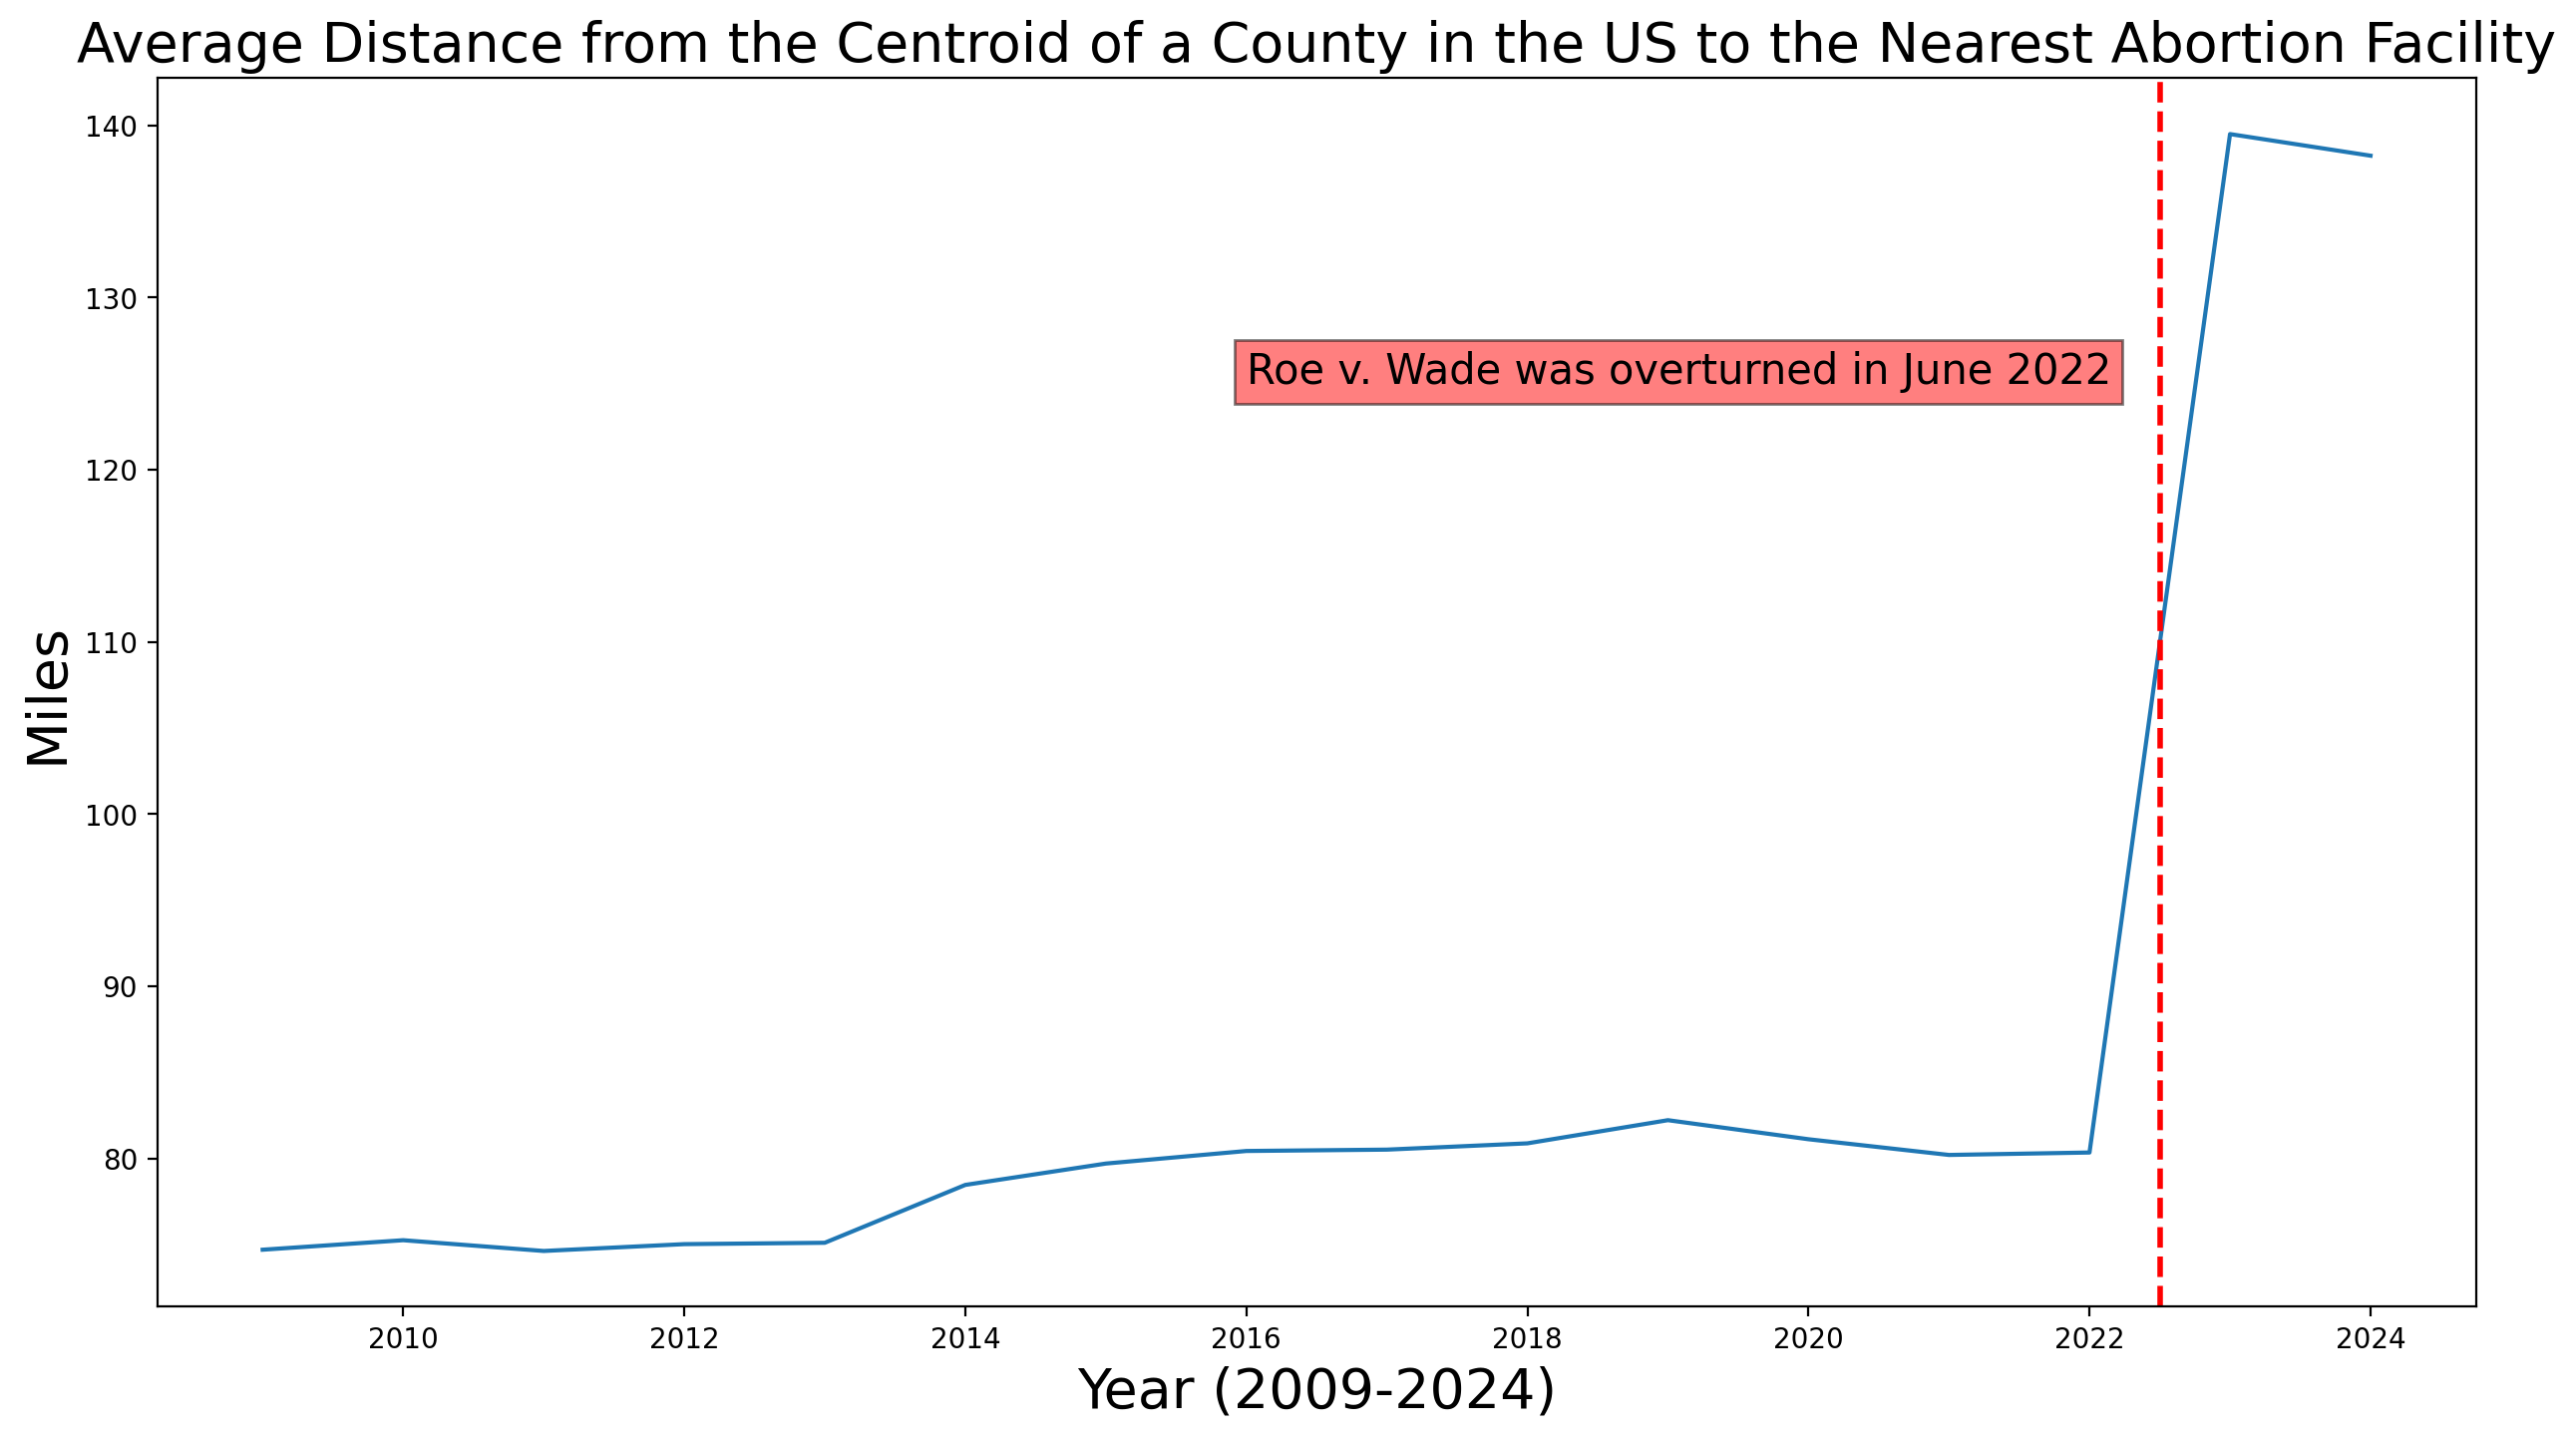

In [23]:
# 2- making a chart showing the average distance to an abortion facility across the whole US over time

distovertime = abortionMAP[['distance_origintodest', 'year']].groupby(by = 'year').mean().plot(figsize=(15,8),legend = False);
distovertime.set_title('Average Distance from the Centroid of a County in the US to the Nearest Abortion Facility', fontsize = 20);
distovertime.set_ylabel('Miles', fontsize = 20);
distovertime.set_xlabel('Year (2009-2024)', fontsize = 20);
distovertime.axvline(x=2022.5, color='red', linestyle='--', linewidth=2);
distovertime.text(2016, 125, "Roe v. Wade was overturned in June 2022", fontsize = 15, bbox=dict(facecolor='red', alpha=0.5));

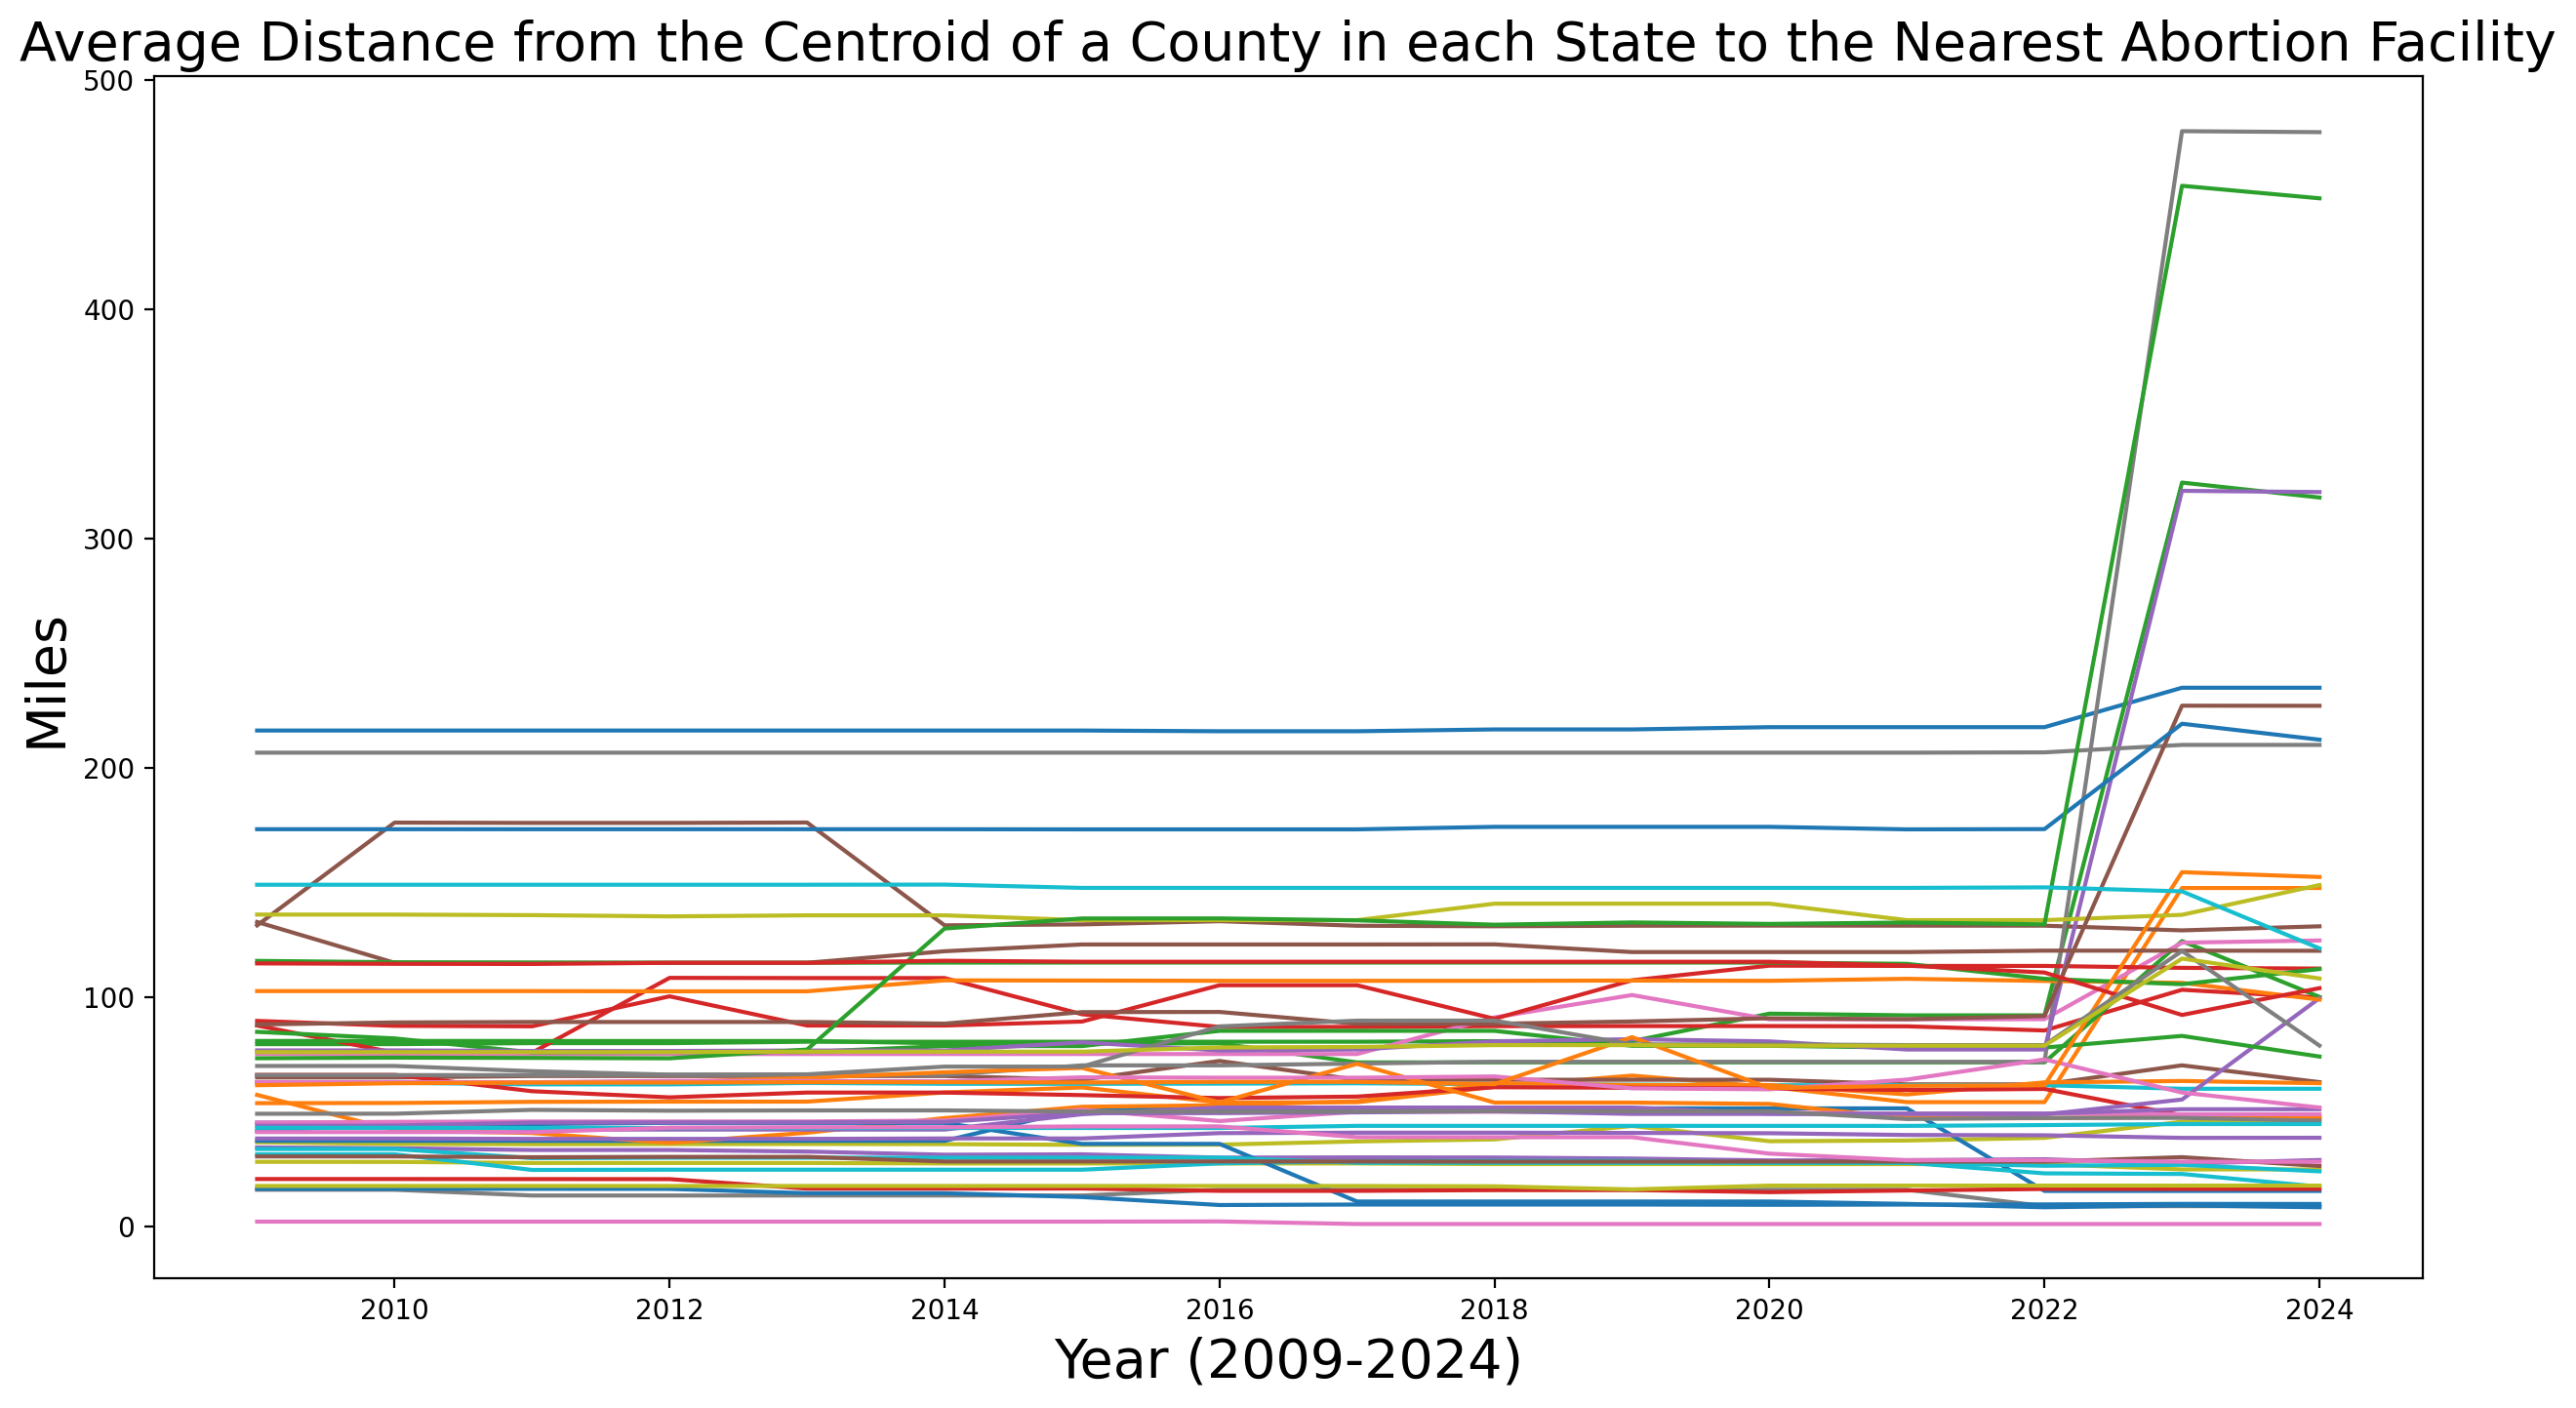

In [24]:
# same graph by state
grouped_df = abortionMAP.groupby(['year', 'origin_state'])['distance_origintodest'].mean().reset_index()
grouped_df['year'] = grouped_df['year'].astype(int)

plt.figure(figsize=(15, 8))

for state in grouped_df['origin_state'].unique():
    state_data = grouped_df[grouped_df['origin_state'] == state]
    plt.plot(state_data['year'], state_data['distance_origintodest'], label=state)

plt.title('Average Distance from the Centroid of a County in each State to the Nearest Abortion Facility', fontsize = 20);
plt.ylabel('Miles', fontsize = 20);
plt.xlabel('Year (2009-2024)', fontsize = 20);

In [17]:
# zoomed in effect for Roe v. Wade overturn
abortionaccessfull['origin_fips_code'] = abortionaccessfull['origin_fips_code'].astype(int)
abortionMAPfull = abortionaccessfull.merge(gdf, left_on='origin_fips_code', right_on='GEOID', how='inner').drop(columns = ['GEOID', 'MTFCC', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOIDFQ',	'NAME',	'NAMELSAD',	'LSAD',	'CLASSFP', 'CSAFP'])
abortionMAPfull = gpd.GeoDataFrame(abortionMAPfull)

abortionMAPzoom = abortionMAPfull[abortionMAPfull['year'] == 2022]

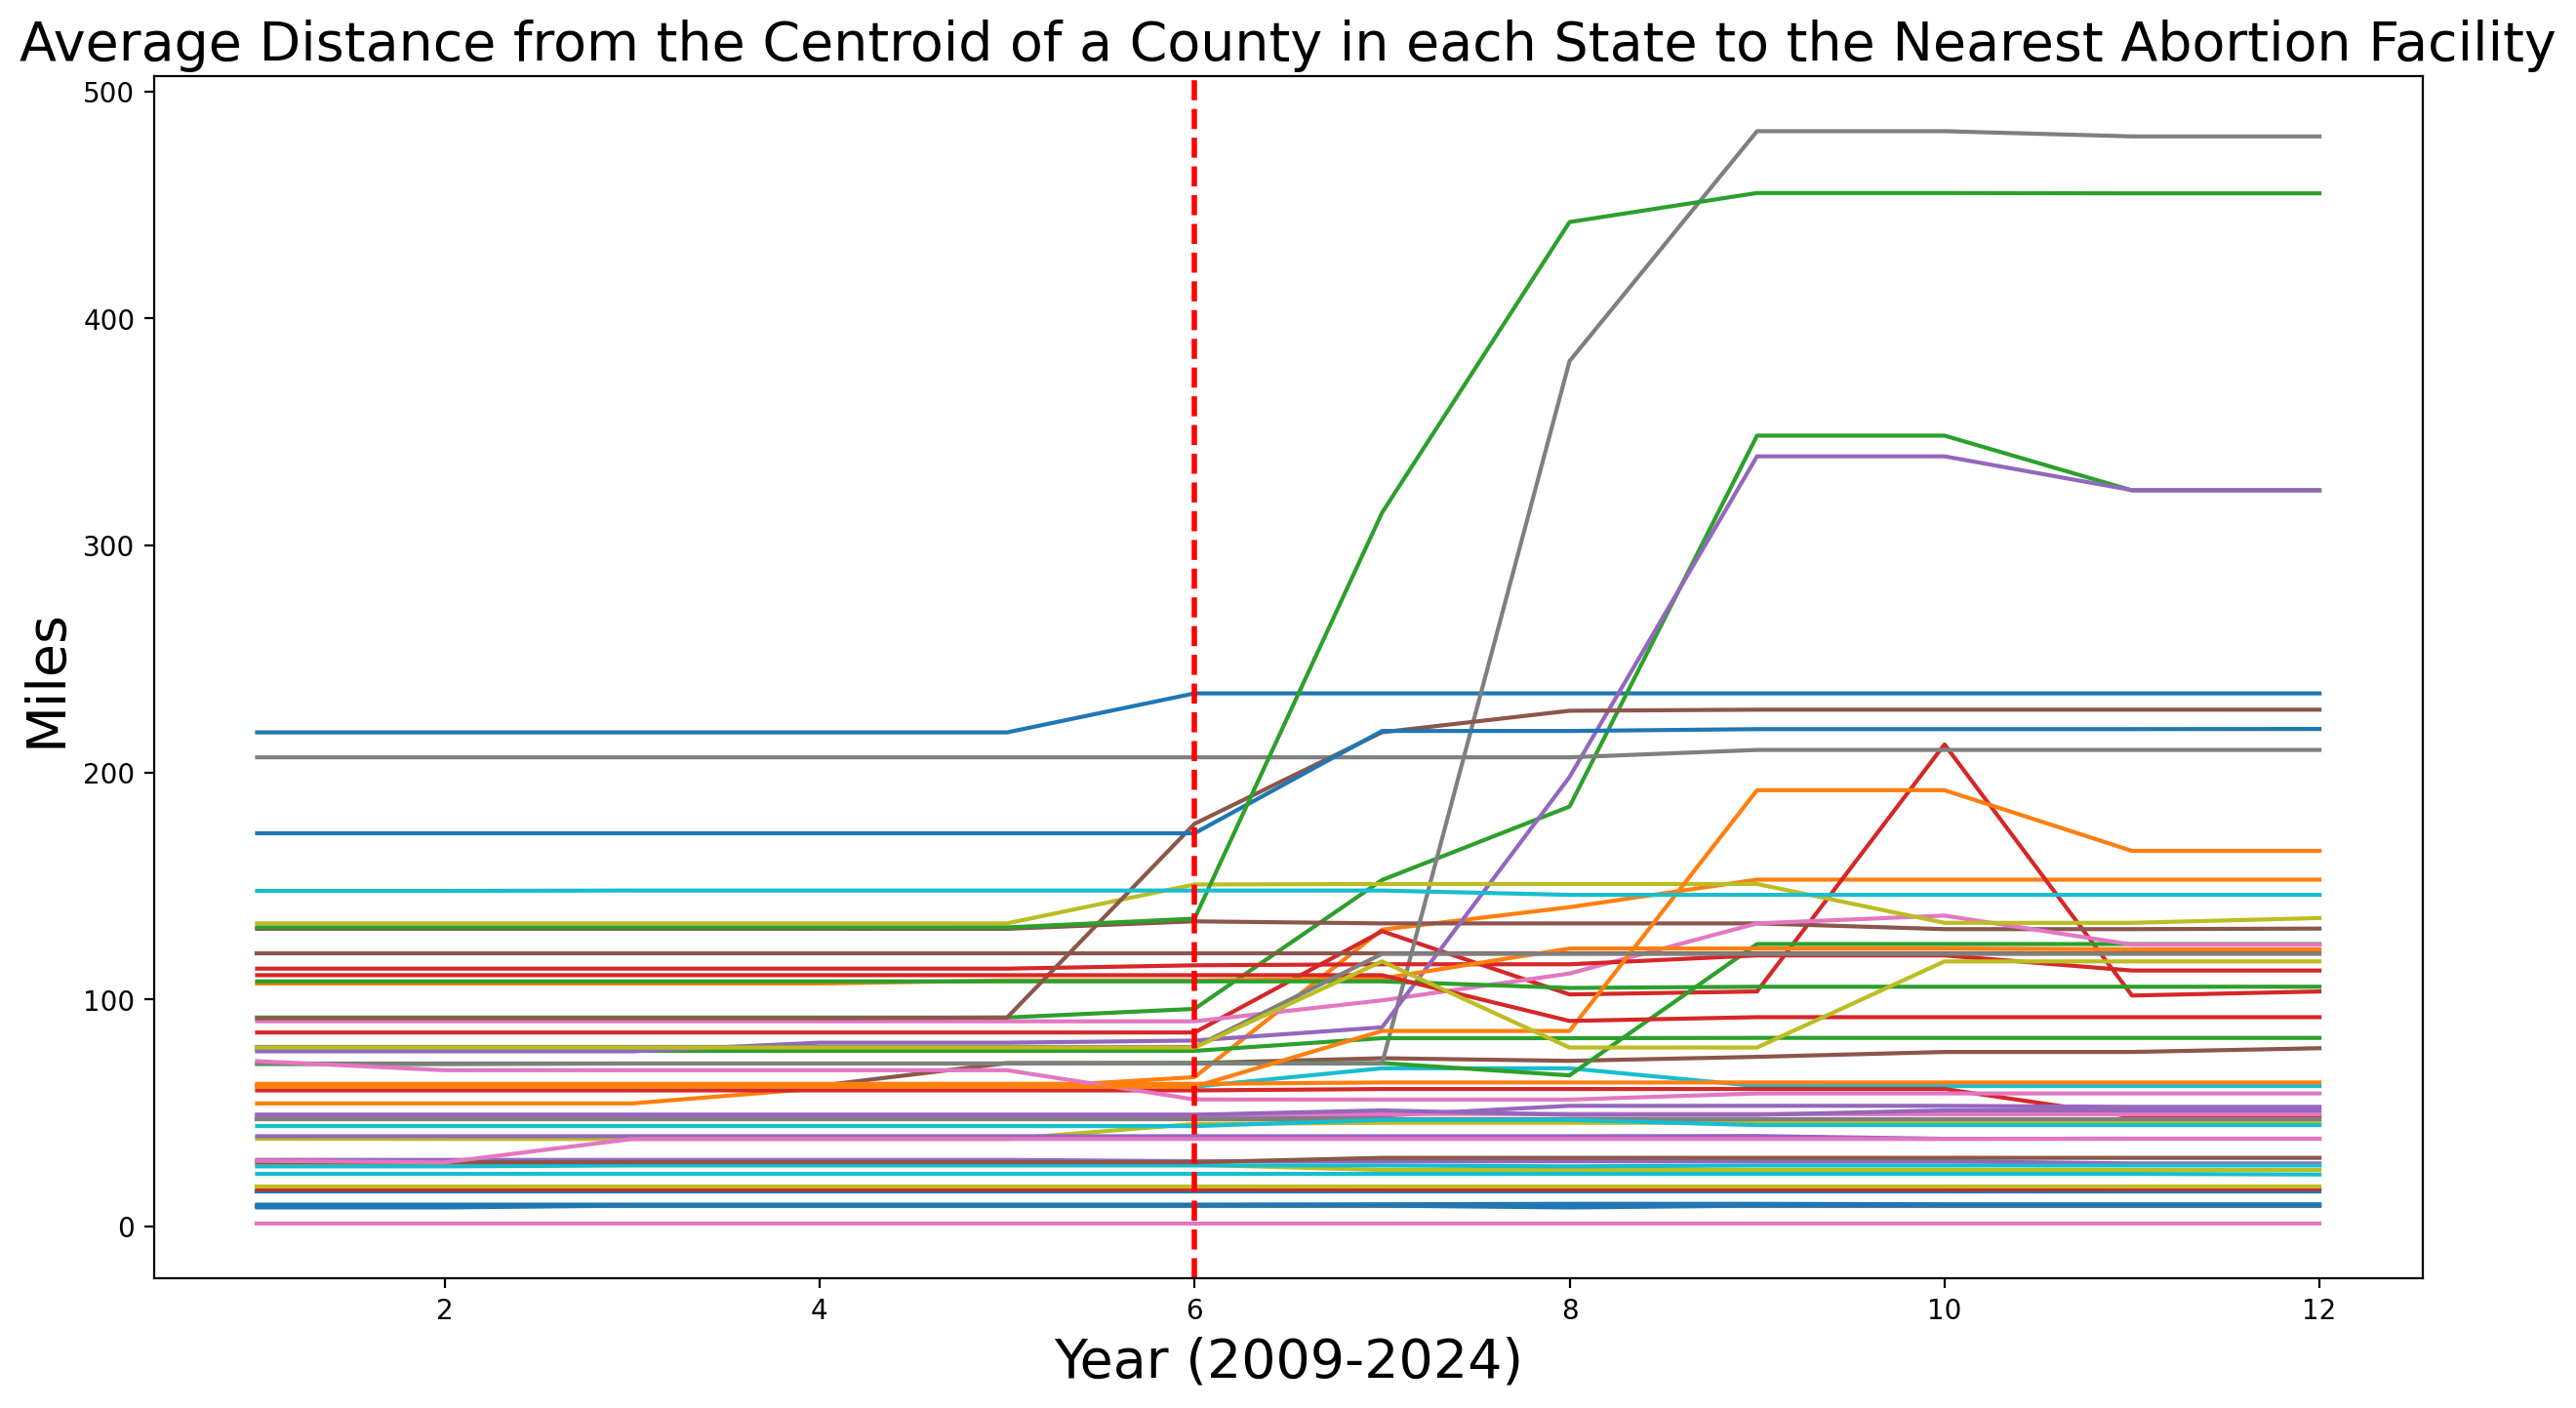

In [22]:
grouped_df = abortionMAPzoom.groupby(['month', 'origin_state'])['distance_origintodest'].mean().reset_index()
grouped_df['month'] = grouped_df['month'].astype(int)

plt.figure(figsize=(15, 8))

for state in grouped_df['origin_state'].unique():
    state_data = grouped_df[grouped_df['origin_state'] == state]
    plt.plot(state_data['month'], state_data['distance_origintodest'], label=state)

plt.title('Average Distance from the Centroid of a County in each State to the Nearest Abortion Facility', fontsize = 20);
plt.ylabel('Miles', fontsize = 20);
plt.xlabel('Month (2022)', fontsize = 20);
plt.axvline(x=6, color='red', linestyle='--', linewidth=2);

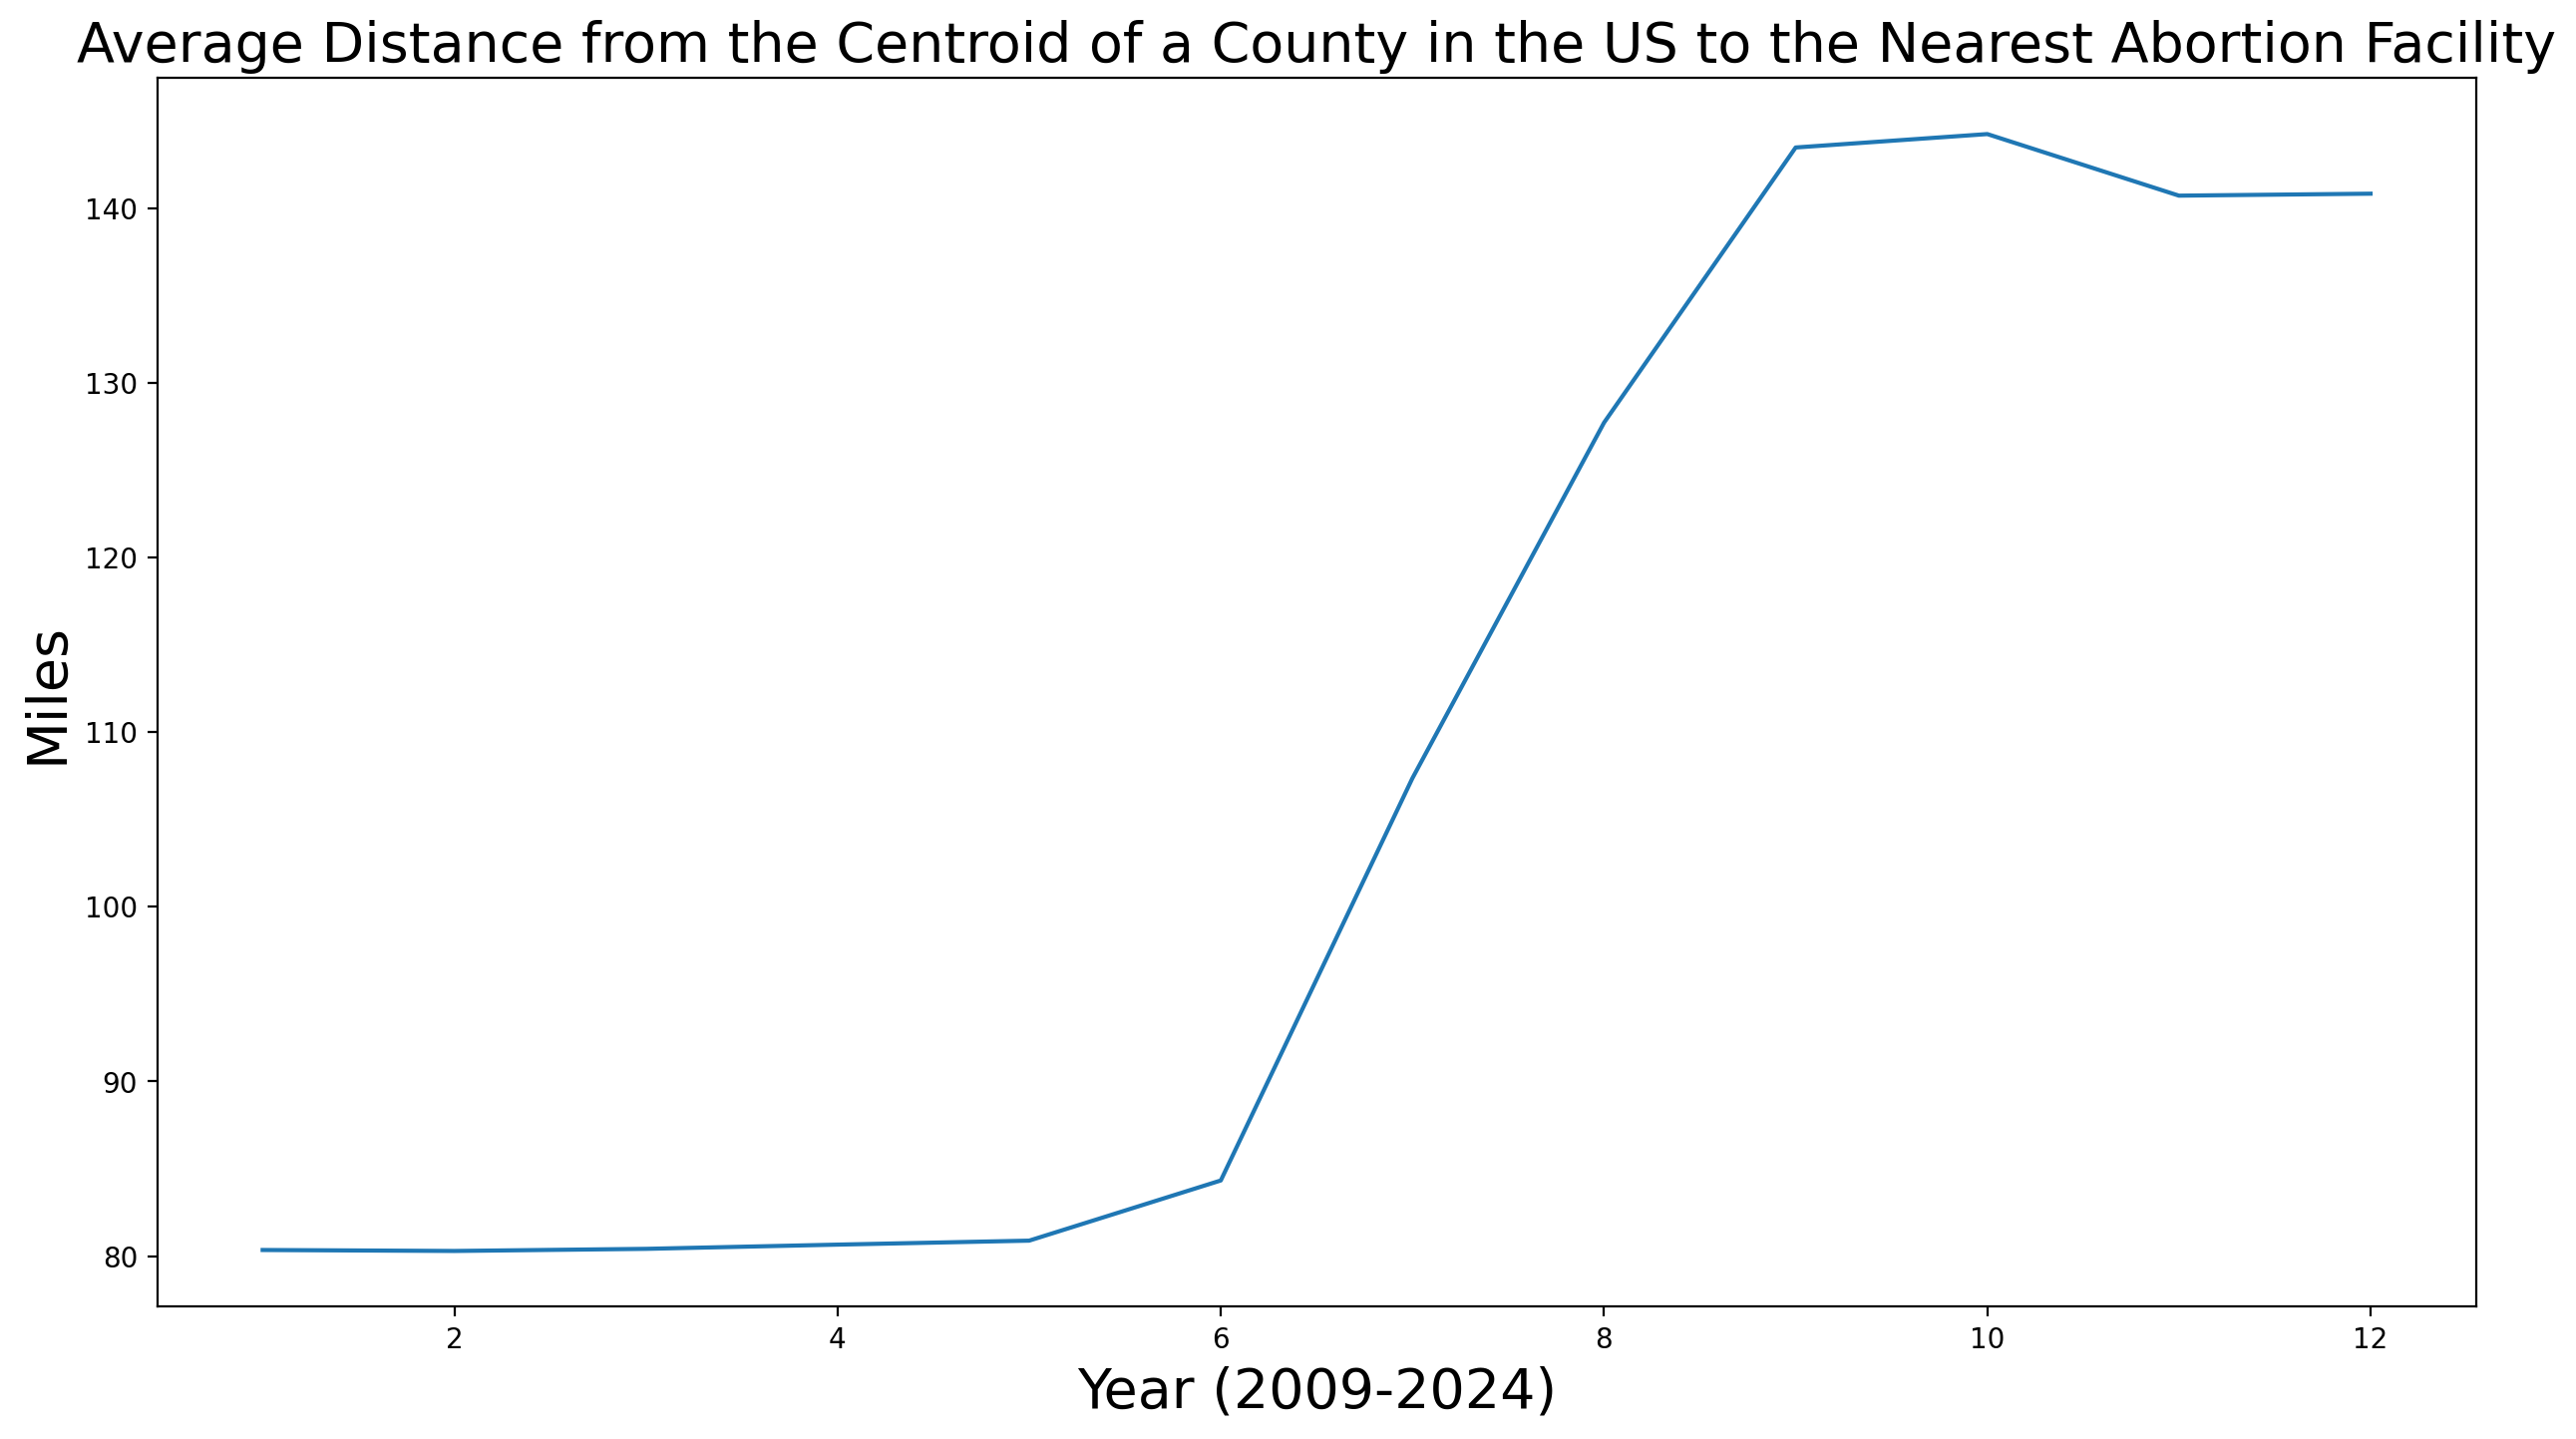

In [19]:
zoom = abortionMAPzoom[['distance_origintodest', 'month']].groupby(by = 'month').mean().plot(figsize=(15,8),legend = False);
# zoom.set_title('Average Distance from the Centroid of a County in the US to the Nearest Abortion Facility', fontsize = 20);
# zoom.set_ylabel('Miles', fontsize = 20);
# zoom.set_xlabel('Year (2009-2024)', fontsize = 20);
#zoom.axvline(x=6, color='red', linestyle='--', linewidth=2);
#zoom.text(2016, 125, "Roe v. Wade was overturned in June 2022", fontsize = 15, bbox=dict(facecolor='red', alpha=0.5));

In [39]:
# 3- analyzing/mapping how the overturn of Roe v Wade the impacted average distace per county

gdf2 = abortionMAP[['year', 'origin_county_name', 'geometry', 'distance_origintodest', 'origin_state']]
gdf2 = gdf2[(gdf2['origin_state'] != 'HI') & (gdf2['origin_state'] != 'AK')]
gdf2 = gdf2[gdf2['year'].isin([2022, 2023])]
gdf2 = gdf2.sort_values(by = ['origin_county_name', 'year'])
gdf2['roe_index'] = gdf2.groupby('origin_county_name')['distance_origintodest'].diff()
gdf2 = gdf2.dropna()

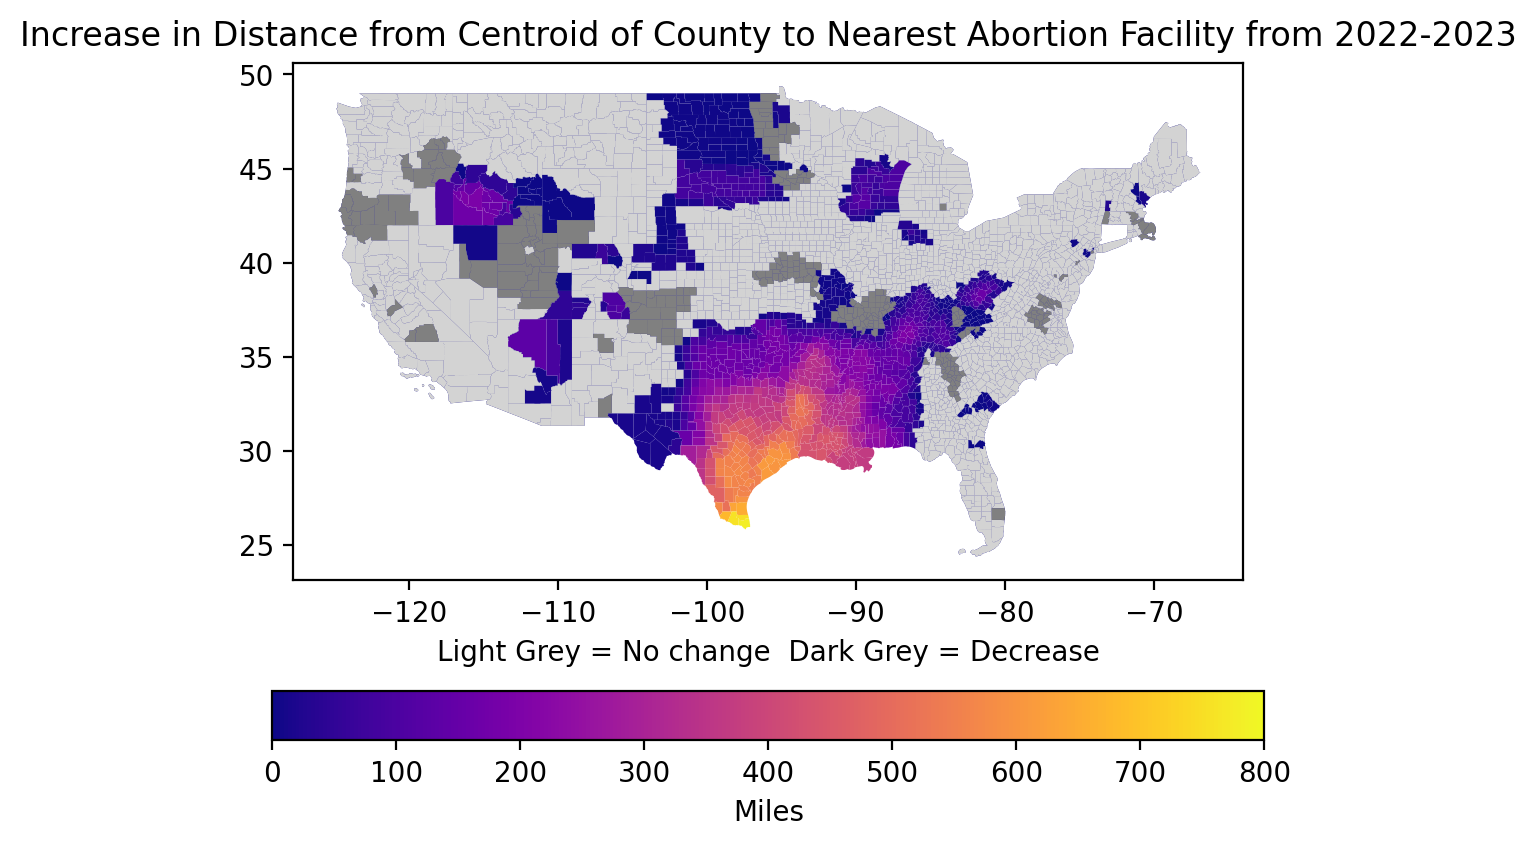

In [40]:
base = gdf2.plot('roe_index', 
                 cmap = 'plasma', 
                 legend = True,
                 vmin = 0, vmax = 800,
                 legend_kwds={'label': "Miles",
                         'orientation': "horizontal"});
layer0 = gdf2[gdf2['roe_index'] == 0].plot(ax = base, color = 'lightgrey');
final = gdf2[gdf2['roe_index'] < 0].plot(ax = base, color = 'grey')
final.set_title('Increase in Distance from Centroid of County to Nearest Abortion Facility from 2022-2023');
final.set_xlabel('Light Grey = No change  Dark Grey = Decrease');

/users/laurel/.local/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/users/laurel/.local/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


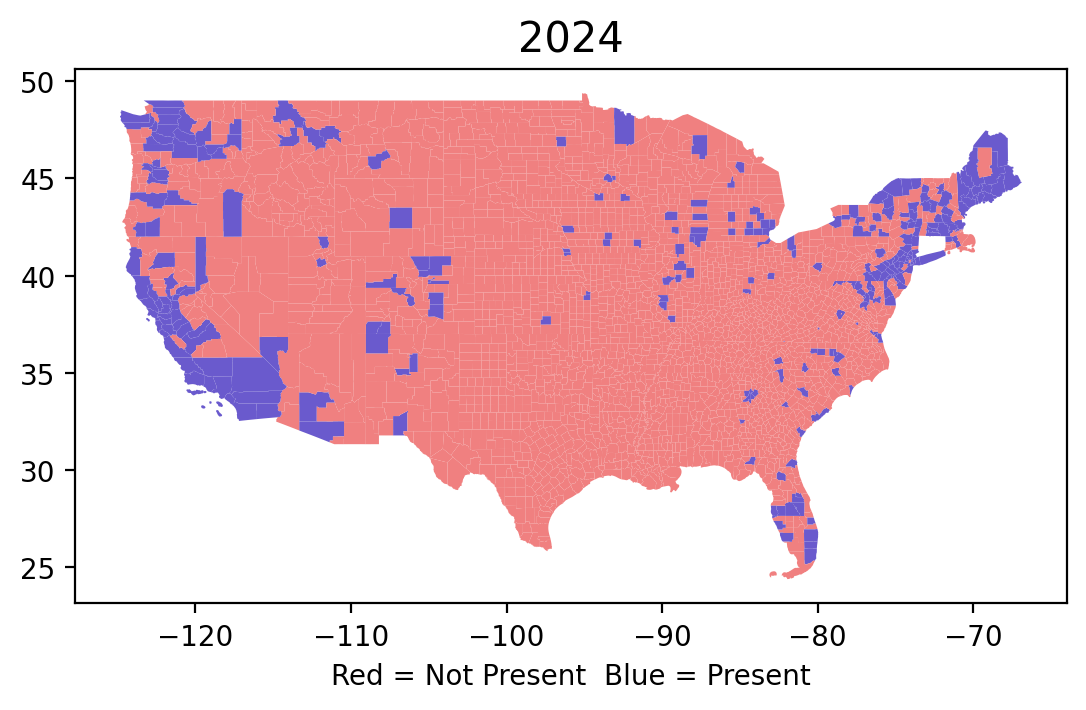

In [28]:
# 4- mapping whether or not a person has to leave their county to get to an abortion facility (changable by year)

abortionMAP10 = abortionMAP[(abortionMAP['year'] == 2024) & (abortionMAP['origin_state'] != 'HI') & (abortionMAP['origin_state'] != 'AK')]

abortionMAP10['samecounty'] = abortionMAP10['origin_county_name'] == abortionMAP10['dest_county_name']

colors = {True: 'slateblue', False: 'lightcoral'}
abortionMAP10['countycolor'] = abortionMAP10['samecounty'].map(colors)

leaveplot = abortionMAP10.plot(color = abortionMAP10['countycolor']);
leaveplot.set_title('2024', fontsize = 15);
leaveplot.set_xlabel('Red = Not Present  Blue = Present');

/tmp/ipykernel_3342464/403221743.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accessplot = access.groupby('year').apply(lambda x: x['origin_population'].sum()/1000000).plot(figsize=(12,6));


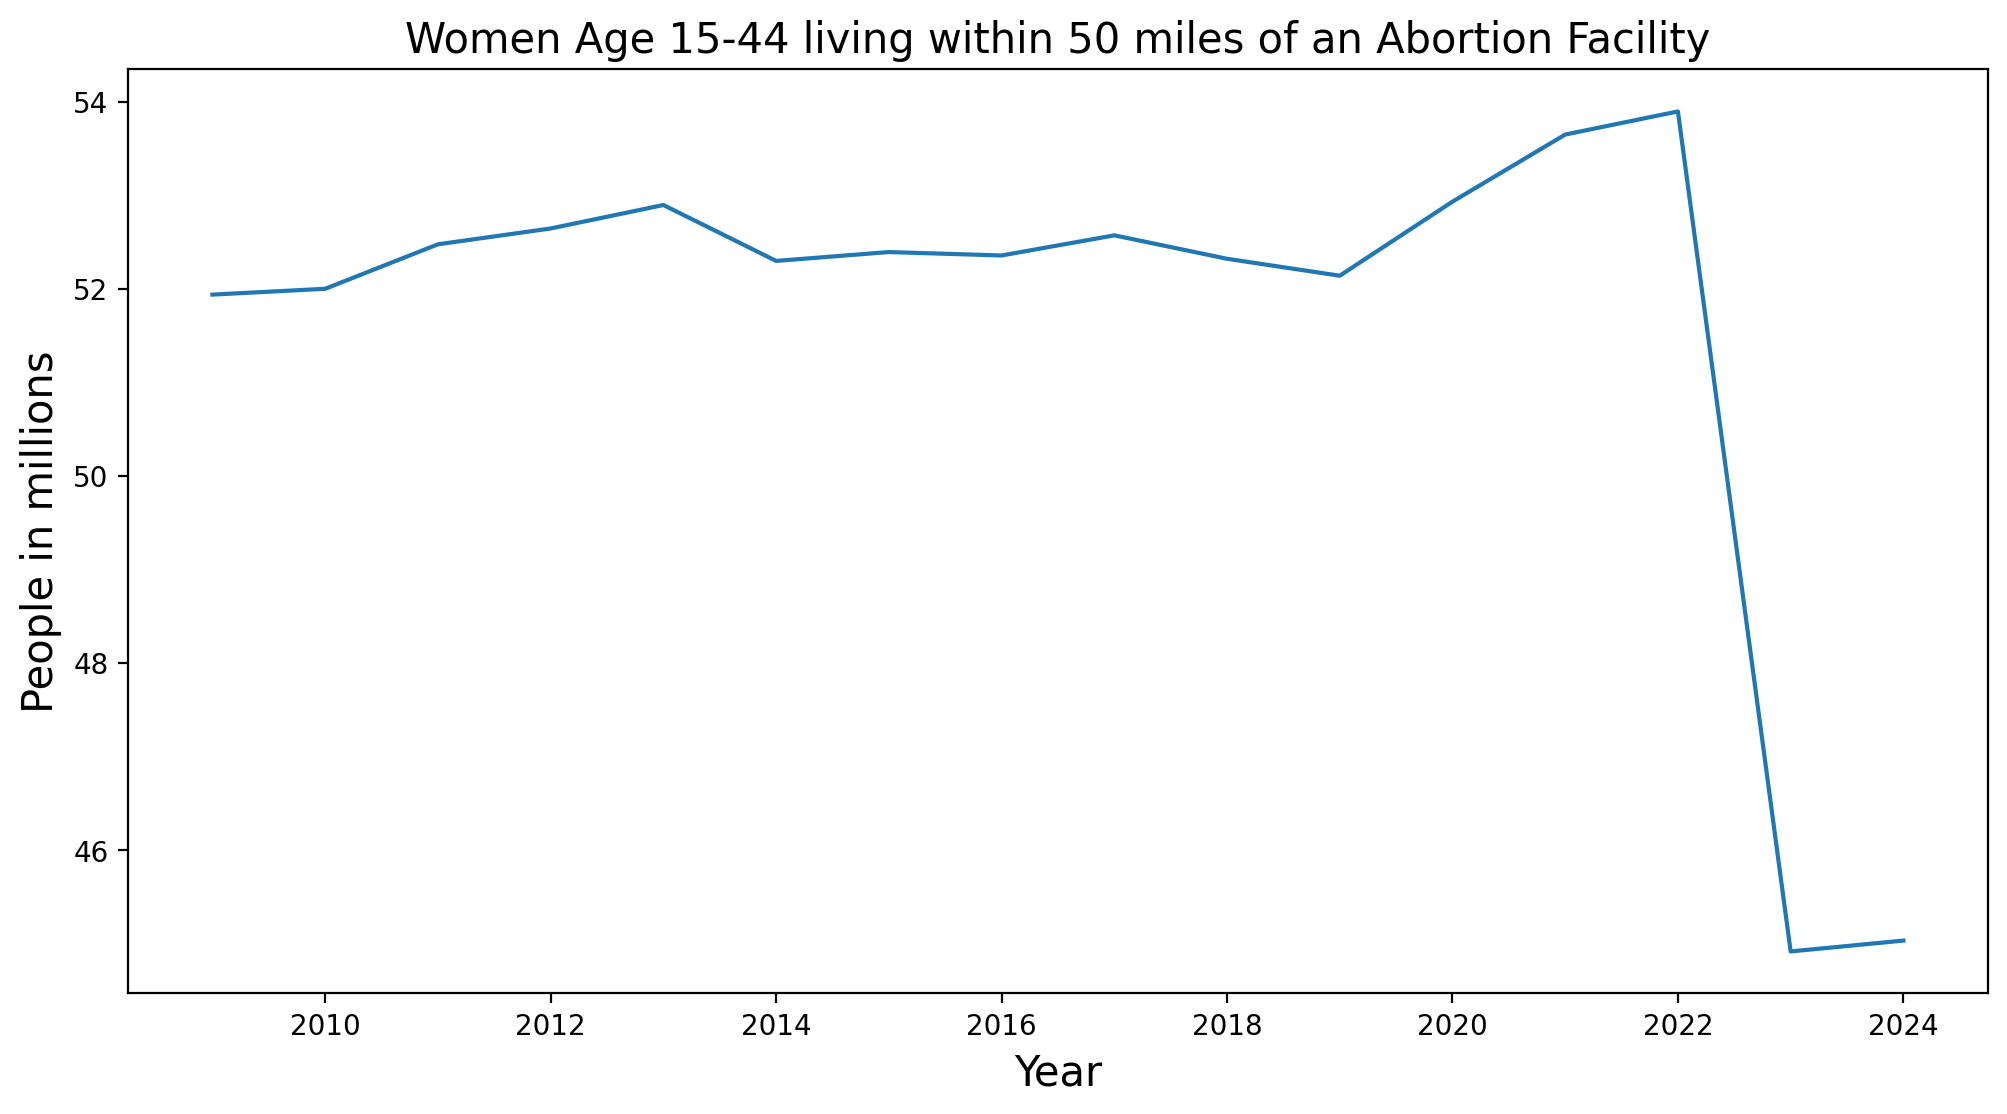

In [31]:
# 5- create a graph that examines number of women who are within 50 miles on an abortion facilityn in the entire US over time
abortionMAP['50miles'] = abortionMAP['distance_origintodest'] <= 50
access = abortionMAP[abortionMAP['50miles'] == True][['origin_population', 'year']]
accessplot = access.groupby('year').apply(lambda x: x['origin_population'].sum()/1000000).plot(figsize=(12,6));
accessplot.set_title('Women Age 15-44 living within 50 miles of an Abortion Facility', fontsize = 15);
accessplot.set_ylabel('People in millions', fontsize = 15);
accessplot.set_xlabel('Year', fontsize = 15);